# 1. 데이터 분석

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  

In [ ]:
data_train = pd.read_csv('DailyDelhiClimateTrain.csv',parse_dates=['date'],index_col='date')
data_test = pd.read_csv('DailyDelhiClimateTest.csv',parse_dates=['date'],index_col='date')
data_train.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
data_train.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


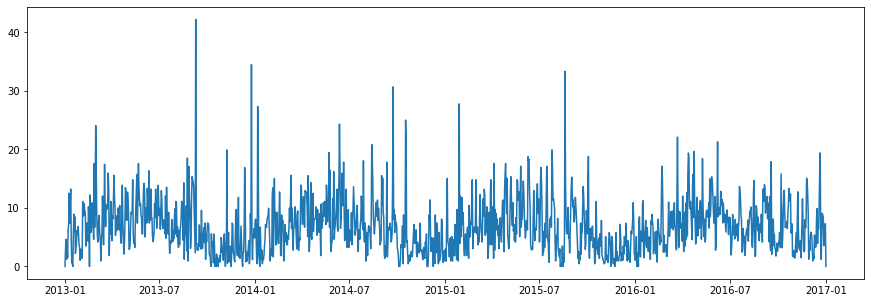

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(data_train['wind_speed'])

# 1.1 Correlation
## 4개의 변수들 간의 상관관계를 분석

<AxesSubplot:>

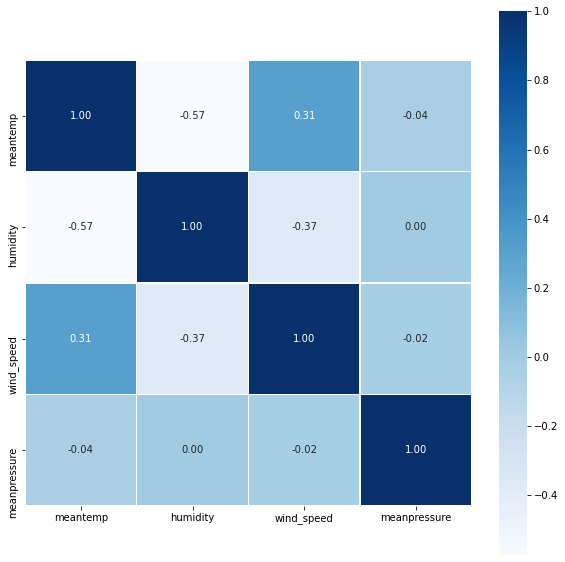

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(data = data_train.corr(), annot=True, 
fmt = '.2f',square='True',linewidths=.5, cmap='Blues')

### 평균 기온과 습도 또는 평균 기온과 풍속 그리고 풍속과 습도에서 0.3 ~ 0.7 사이의 유의미한 선형상관관계를 가진다.

# 1.2 Causality
### 시계열 데이터에서 특정 변수가 다른 변수의 원인이 되는지 알아보기 위한 인과관계 검정
### Granger 검정을 실시

<AxesSubplot:>

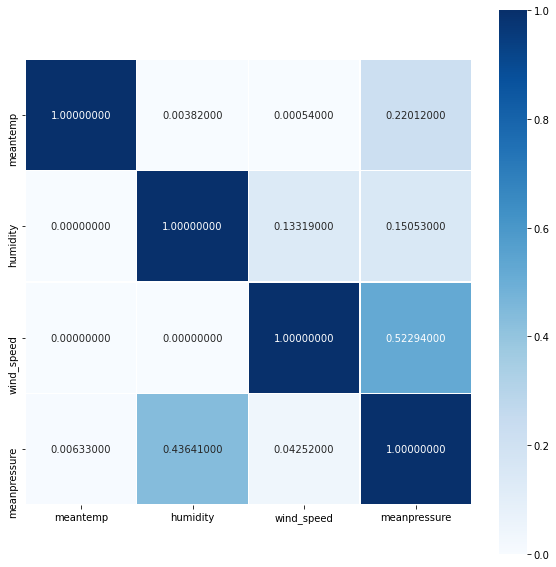

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests

variables = data_train.columns
maxlag=12
test = 'ssr_chi2test'

cause = pd.DataFrame(np.zeros((len(variables),len(variables))),columns=variables,index=variables)
for c in variables:
    for r in variables:
        x = grangercausalitytests(data_train[[r,c]],maxlag=maxlag,verbose=False)
        p_values = [round(x[i+1][0][test][1],5) for i in range(maxlag)]
        min_value = np.min(p_values)
        cause.loc[r,c] = min_value

cause

plt.figure(figsize=(10,10))
sns.heatmap(data = cause, annot=True, 
fmt = '.8f',square='True',linewidths=.5, cmap='Blues')

### 유의수준 0.05보다 유의확률이 작으면 두 변수간의 인과관계가 없다는 귀무가설을 기각한다.
### 다수의 인과관계가 존재

# 2.데이터 전처리

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
St_sc=StandardScaler()
train_st=St_sc.fit_transform(data_train.values[:,])
mm_sc=MinMaxScaler()
train_mm=mm_sc.fit_transform(train_st)
test=mm_sc.transform(St_sc.transform(data_test.values[:,]))

# 3. 모델 학습

## 3.1 조기멈춤 설정
#### loss값이 5회 이상 줄어들지 않을 시 학습을 중지한다.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping,ModelCheckpoint

es= EarlyStopping(monitor='loss',mode='min',verbose=0,patience=5)

In [ ]:
X_train=np.asarray(train_mm[0:len(data_train)-2])
y_train=np.asarray(train_mm[1:len(data_train)-1])

In [ ]:
X_test=np.asarray(test[0:len(data_test)-2]).astype('float32')
y_test=np.asarray(test[1:len(data_test)-1]).astype('float32')

### 데이터의 마지막 전날까지의 기후를 X값, 둘째날부터 마지막날까지를 y값으로 설정해 지도학습처럼 학습

## 3.2 적절한 은닉층의 개수 찾기

In [ ]:
x=list(range(2,30))
testscores=[]
for i in x:
    model_hl=Sequential()
    model_hl.add(Dense(32, input_shape=(4,), activation='relu'))
    for j in range(1,i):
        model_hl.add(Dense(32, activation='relu'))
    model_hl.add(Dense(4))    
    model_hl.compile(loss='mean_squared_error', optimizer='adam')
    hist_hl = model_hl.fit(X_train, y_train, batch_size=16, epochs=1000,callbacks=[es],verbose=0)

    testScore=model_hl.evaluate(X_test, y_test, batch_size=16, verbose=0)
    testscores.append([i-1,testScore])
testscores=np.array(testscores)
n_hidden_layer=testscores[:,0][np.where(testscores[:,1]==(min(testscores[:,1])))][0].astype(np.int64)

In [ ]:
n_hidden_layer

3

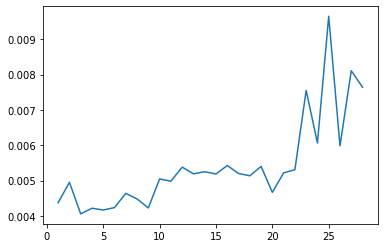

In [ ]:
plt.plot(testscores[:,0],testscores[:,1])

### 대부분 1층에서 10층 사이

## 3.3 적절한 은닉층의 노드수 찾기

In [ ]:
model_i=Sequential()
testscores=[]
for i in range(10,40):
    model_n=Sequential()
    model_n.add(Dense(i, input_shape=(4,), activation='relu'))
    for j in range(n_hidden_layer):
        model_n.add(Dense(i, activation='relu'))
    model_n.add(Dense(4))
    model_n.compile(loss='mean_squared_error', optimizer='adam')
    hist_n = model_n.fit(X_train, y_train, batch_size=16, epochs=1000,callbacks=[es],verbose=0)

    testScore=model_n.evaluate(X_test, y_test, batch_size=16, verbose=0)
    testscores.append([i,testScore])
testscores=np.array(testscores)
n_node=testscores[:,0][np.where(testscores[:,1]==(min(testscores[:,1])))][0].astype(np.int64)

In [ ]:
n_node

22

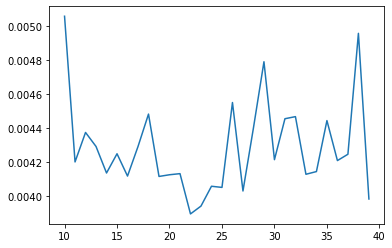

In [ ]:
plt.plot(testscores[:,0],testscores[:,1])

### 대부분 10개에서 30개 사이

## 3.4 적절한 optimizer 찾기

In [ ]:
model_o=Sequential()
model_o.add(Dense(n_node, input_shape=(4,), activation='relu'))
for i in range(n_hidden_layer):
    model_o.add(Dense(n_node, activation='relu'))
model_o.add(Dense(4))

optimizers=["SGD","RMSprop","Adagrad","Adadelta","Adam","Adamax","Nadam"]
testscores=[]
for x in optimizers:
    model_o.compile(loss='mean_squared_error', optimizer=x)
    hist_o = model_o.fit(X_train, y_train, batch_size=16, epochs=1000,callbacks=[es],verbose=0)
    testScore=model_o.evaluate(X_test, y_test, batch_size=16, verbose=0)
    testscores.append([x,testScore])
testscores=np.array(testscores)
optimizer=testscores[:,0][np.where(testscores[:,1]==(min(testscores[:,1])))][0]

In [ ]:
optimizer

'Adadelta'

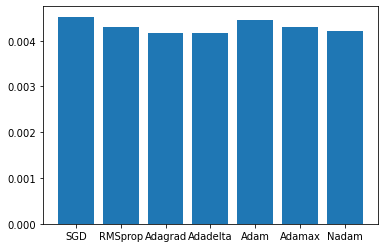

In [ ]:
index=np.arange(len(optimizers))
plt.bar(index,testscores[:,1].astype(np.float64))
plt.xticks(index,testscores[:,0])
plt.show()

## 3.5 위의 경우를 모두 고려한 모델 작성

In [ ]:
model1=Sequential()
model1.add(Dense(n_node, input_shape=(4,), activation='relu'))
for i in range(n_hidden_layer):   
    model1.add(Dense(n_node, activation='relu'))
model1.add(Dense(4))

model1.summary()

model1.compile(loss='mean_squared_error', optimizer=optimizer)

hist = model1.fit(X_train, y_train, batch_size=16, epochs=1000,callbacks=[es],verbose=0)

trainScore=model1.evaluate(X_train, y_train, batch_size=16, verbose=0)
print('Train Score :', trainScore)

testScore=model1.evaluate(X_test, y_test, batch_size=16, verbose=0)
print('Test Score :', testScore)

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_617 (Dense)            (None, 22)                110       
_________________________________________________________________
dense_618 (Dense)            (None, 22)                506       
_________________________________________________________________
dense_619 (Dense)            (None, 22)                506       
_________________________________________________________________
dense_620 (Dense)            (None, 22)                506       
_________________________________________________________________
dense_621 (Dense)            (None, 4)                 92        
Total params: 1,720
Trainable params: 1,720
Non-trainable params: 0
_________________________________________________________________
Train Score : 0.007292257621884346
Test Score : 0.006691859569400549


## 4. 학습 결과 분석
### 학습한 모델을 이용하여 테스트 데이터 예측

In [ ]:
model1_pred=model1.predict(X_test,batch_size=16)

## 4.1 예측한 데이터 반정규화

In [ ]:
inverse_pred=St_sc.inverse_transform(mm_sc.inverse_transform(model1_pred))
inverse_test=St_sc.inverse_transform(mm_sc.inverse_transform(y_test))

## 4.2 평균기온

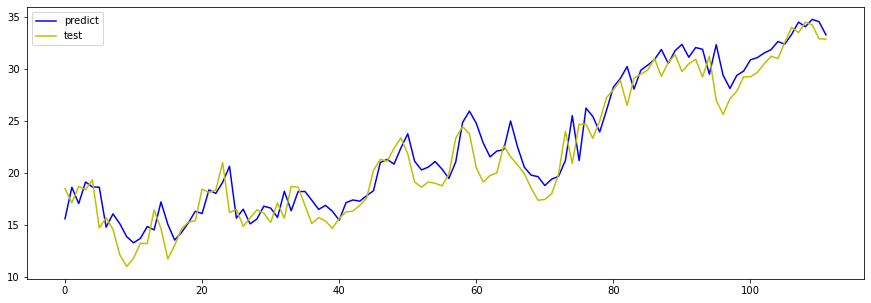

In [ ]:
plt.figure(figsize = (15,5))
plt.plot(inverse_pred[:,0],'b',label='predict')
plt.plot(inverse_test[:,0],'y',label='test')
plt.legend()
plt.show()

# 5.모델 평가

### 5.1 평균 기온의 MSE 계산

In [ ]:
((inverse_pred[:,0]-inverse_test[:,0])**2).mean()

3.5489337

### 5.2 오차를 설정해 실제 기온과의 차이가 오차범위 이내일 경우 정답이라 판단, 그렇지 않을 경우 오답이라 판단하여 정확도를 측정

In [ ]:
percent=[]
for i in range(len(y_test)):
    if abs(inverse_pred[:,0][i]-inverse_test[:,0][i])<=2.5:
        percent.append(1)
    else:percent.append(0)
print('{}%'.format(sum(percent)/len(percent)*100))

82.14285714285714%
